In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Image preprocessing (128x128)

In [41]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from pathlib import Path
from PIL import Image
from tqdm import tqdm

The original images are cropped to center the characters and resized to 128x128. We add padding to maintain the aspect ratio.

In [5]:
IMG_HEIGHT = 137
IMG_WIDTH = 236
SIZE = 128
DATA_PATH = Path('../input')

In [38]:
def bbox(mask):
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(image, size, pad=16):
    # Get the bbox around pixels darker than threshold 80
    rmin, rmax, cmin, cmax = bbox(image < 80)
    
    # Give breathing room to the bbox
    rmin = max(0, rmin - 13)
    rmax = min(IMG_HEIGHT, rmax + 10)
    cmin = max(0, cmin - 10)
    cmax = min(IMG_WIDTH, cmax + 10)
    
    # Crop
    image = image[rmin:rmax, cmin:cmax]
    
    # Remove bright pixels
    image[image > 227] = 255
    
    # Pad image to preserve aspect ratio after rescaling
    height = rmax - rmin
    width = cmax - cmin
    dim = max(height, width) + pad
    image = np.pad(image, [((dim - height) // 2,), ((dim - width) // 2,)],
                   mode='constant', constant_values=255)

    # Resize
    image = Image.fromarray(image).resize((size, size))

    return np.array(image, dtype=np.uint8)

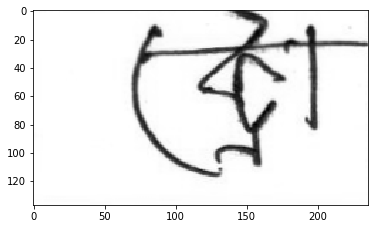

In [39]:
image = joblib.load(DATA_PATH/'image_pickles/Train_0.pkl')
image = image.reshape(IMG_HEIGHT, IMG_WIDTH)
plt.imshow(image, cmap='gray')

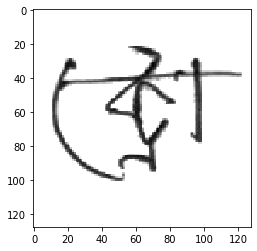

In [40]:
plt.imshow(crop_resize(image, SIZE), cmap='gray')

In [42]:
n_images = 8
PICKLE_DATA_PATH = DATA_PATH / 'image_pickles'

In [44]:
images = [(joblib.load(PICKLE_DATA_PATH / f'Train_{file_idx}.pkl')
                 .reshape(IMG_HEIGHT, IMG_WIDTH)) for file_idx in range(n_images)]

images_processed = [crop_resize(img, SIZE) for img in images]

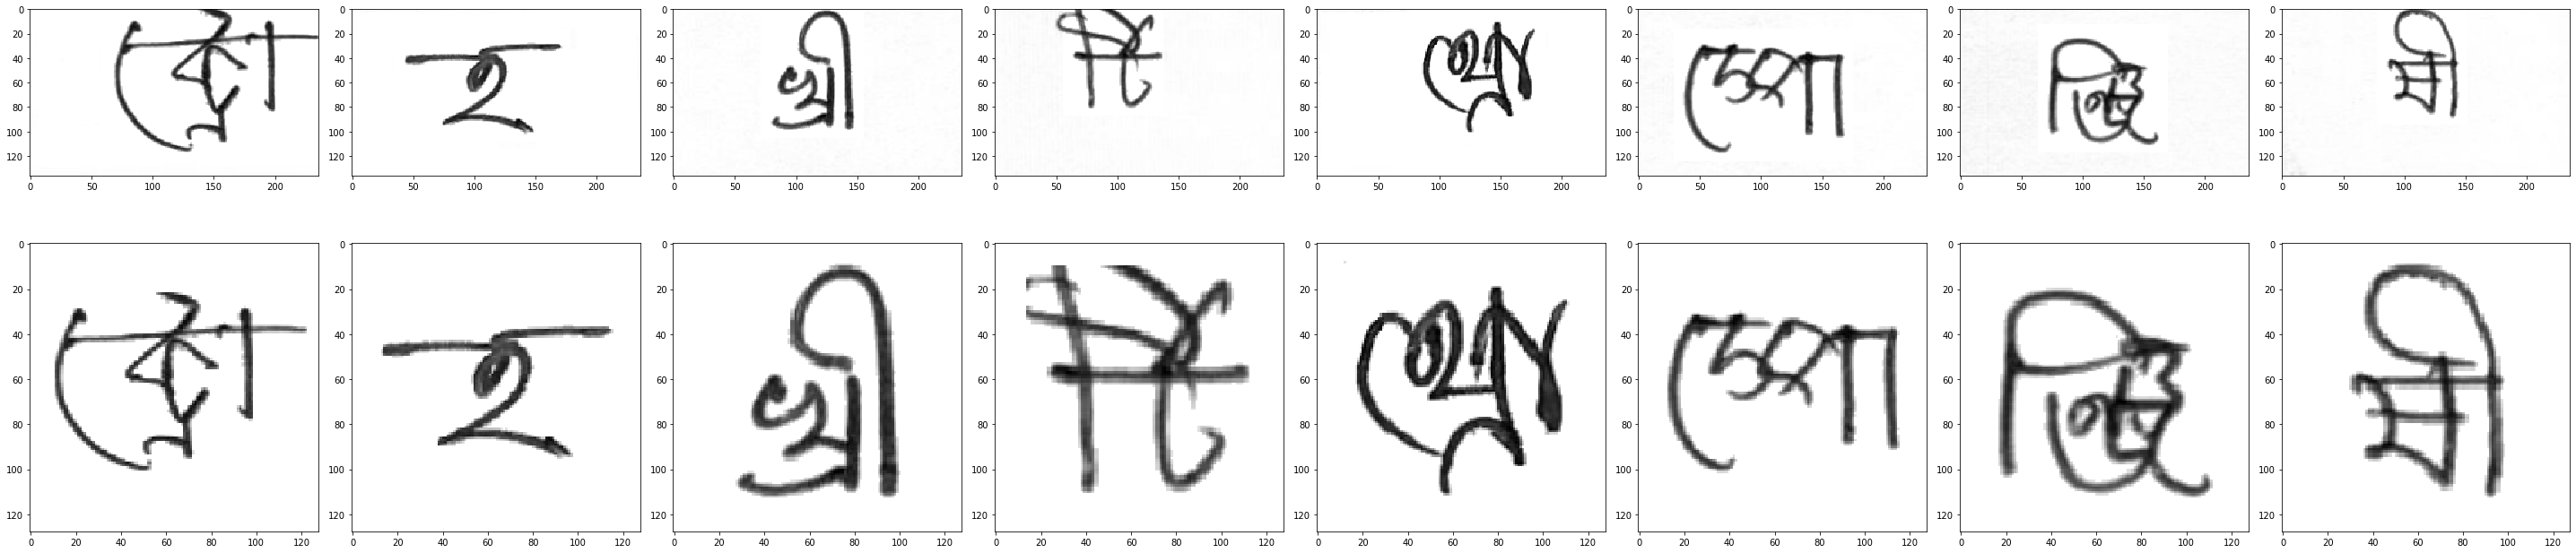

In [47]:
fig, axes = plt.subplots(2, n_images, figsize=(5 * n_images, 10))

for idx, (image, image_cropped) in enumerate(zip(images, images_processed)):
    axes[0, idx].imshow(image, cmap='gray')
    axes[1, idx].imshow(image_cropped, cmap='gray')
plt.tight_layout()